In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

#from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import pairwise_distances

#from gensim.models.coherencemodel import CoherenceModel

#import TextCleaning_update

In [2]:
# pull in old 2018 raw abstracts
old = pd.read_csv('../../data/original/raw_abstracts.csv',engine='python')

# remove null abstracts and duplicates
#olddf = TextCleaning.remove_nulls(raw_df, "ABSTRACT")
#olddf = TextCleaning.remove_duplicates(df)

old.reset_index(inplace = True)
old.rename(columns={'index':'original index'}, inplace=True)

In [3]:
#import new data with 2019 added

raw = pd.read_csv('../../data/original/working_federal_reporter_2020.csv',engine='python')

In [4]:
#df = new
#df = TextCleaning.remove_nulls(new, "ABSTRACT")
#df = TextCleaning.remove_duplicates(df)

raw.reset_index(inplace = True)
raw.rename(columns={'index':'original index'}, inplace=True)

## Assess difference between two 'FY' columns

In [5]:
disagree_years = raw[raw['FY.x'] != raw['FY.y']][['FY.x','FY.y']]
disagree_years.isnull().sum()

FY.x    35035
FY.y       19
dtype: int64

In [6]:
#Fill NAs in FY.x column with values from FY.y
raw['FY.x'] = raw['FY.x'].fillna(raw['FY.y'])

In [7]:
#recheck where FY columns are mismatched
raw[raw['FY.x'] != raw['FY.y']][['FY.x','FY.y']].isnull().sum()

FY.x     0
FY.y    19
dtype: int64

In [8]:
raw[raw['FY.x'] != raw['FY.y']][['FY.x','FY.y']]

,FY.x,FY.y
16282,2008.0,NaN
50636,2008.0,NaN
73128,2008.0,NaN
73784,2008.0,81405.0
73807,2008.0,329831.0
87421,2008.0,7073.0
126758,2009.0,NaN
154276,2009.0,NaN
187001,2009.0,320749.0
187618,2009.0,79171.0


In [9]:
#rename 'FY.x' as 'FY' to fit downstream code
raw = raw.rename(columns={'FY.x': 'FY'})

In [10]:
#drop FY.y columns
raw = raw.drop(['FY.y'], axis=1)

# DE-DUPLICATION

In [11]:
# check to make sure "original index" columns do not have different values
(raw['original index'] != raw['original index']).sum()

0

In [12]:
raw = raw.drop(['original index'], axis=1)

In [13]:
#each row has a unique Project ID
pid = raw.PROJECT_ID.value_counts()> 1
pid.sum()

0

In [14]:
#Some PROJECT_NUMBERs are repeated
pnum = raw.PROJECT_NUMBER.value_counts()> 1
pnum.sum()

3605

In [15]:
#There are no rows that are exactly the same.
raw[raw.duplicated(subset=None, keep='first')]

,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,...,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS


In [16]:
len(
    raw[raw.duplicated(subset=['ABSTRACT', 'FY', 'PROJECT_TITLE', 'DEPARTMENT', 'AGENCY', 'PROJECT_TERMS',
      'PROJECT_START_DATE', 'PROJECT_END_DATE', 'CONTACT_PI_PROJECT_LEADER', 
       'FY_TOTAL_COST', 'FY_TOTAL_COST_SUB_PROJECTS'], keep='first')]
)

3369

In [17]:
len(raw[raw.duplicated(subset=['PROJECT_NUMBER'], keep='last')]
   )

6485

In [95]:
duplicates = raw[raw.duplicated(subset=['ABSTRACT',  'PROJECT_TITLE', #'DEPARTMENT', 'AGENCY', #'PROJECT_TERMS','FY',
      'PROJECT_START_DATE', #'PROJECT_END_DATE', 
                            # 'ORGANIZATION_NAME',
                             #'CONTACT_PI_PROJECT_LEADER', 
      # 'FY_TOTAL_COST', #'FY_TOTAL_COST_SUB_PROJECTS'
                        ], keep='first')]

In [18]:
len(duplicates)

512292

In [19]:
raw = raw.sort_values(['PROJECT_END_DATE'])

In [20]:
dedup = raw[~raw.duplicated(subset=['ABSTRACT',  'PROJECT_TITLE', #'DEPARTMENT', 'AGENCY', #'PROJECT_TERMS','FY',
      'PROJECT_START_DATE', #'PROJECT_END_DATE', 
                            # 'ORGANIZATION_NAME',
                             #'CONTACT_PI_PROJECT_LEADER', 
      # 'FY_TOTAL_COST', #'FY_TOTAL_COST_SUB_PROJECTS'
                        ], keep='last')]


In [21]:
len(dedup)

643845

#### How many different organizations are there within each group of duplicate rows?

In [98]:
duplicates.groupby('ABSTRACT')['ORGANIZATION_NAME'].value_counts('ORGANIZATION_NAME')

ABSTRACT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Null ABSTRACT values

In [22]:
len(raw[raw.ABSTRACT.isnull()])

42380

In [23]:
len(dedup[dedup.ABSTRACT.isnull()])

15131

In [24]:
len(raw[raw.PROJECT_TITLE.isnull()])

0

In [25]:
# create df as dedup, dropping NAN abstracts
df = dedup[~dedup.ABSTRACT.isnull()]

In [26]:
len(df)

628714

In [27]:
df[df.ABSTRACT == '']

,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,...,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS


In [28]:
# drop abstracts with values of "ABSTRACT NOT PROVIDED" and "No abstract provided "
df = df[df.ABSTRACT != 'ABSTRACT NOT PROVIDED']
df = df[df.ABSTRACT != 'No abstract provided']
len(df)

628066

In [29]:
# Abstract w/ highest occurances in raw (2019) data
common_raw = raw[raw.ABSTRACT == "The Vaccine and Treatment Evaluation Units (VTEUs) are a consortium of individual contracts within academic centers and organizations that provide a ready resource for the design and conduct of clinical trials to evaluate promising vaccines and treatments for infectious disease. Investigations of novel product delivery systems and routes of delivery may also be conducted. In general, products will be evaluated in normal healthy populations; however, access to special populations is also available."]

In [30]:
len(common_raw)

258

In [31]:
# Abstract w/ highest occurances in de-duplicated and -NAN  2019 data
common_df = df[df.ABSTRACT == "The Vaccine and Treatment Evaluation Units (VTEUs) are a consortium of individual contracts within academic centers and organizations that provide a ready resource for the design and conduct of clinical trials to evaluate promising vaccines and treatments for infectious disease. Investigations of novel product delivery systems and routes of delivery may also be conducted. In general, products will be evaluated in normal healthy populations; however, access to special populations is also available."]

In [32]:
len(common_df)

86

In [33]:
# High Count Abstract in raw 2019 data

common_raw[['FY', 'FY_TOTAL_COST', 'CONTACT_PI_PROJECT_LEADER', 'PROJECT_TITLE', 'PROJECT_START_DATE', 'PROJECT_END_DATE']]#.sort_values()

,FY,FY_TOTAL_COST,CONTACT_PI_PROJECT_LEADER,PROJECT_TITLE,PROJECT_START_DATE,PROJECT_END_DATE
762148,2015.0,244997.0,"WINOKUR, PATRICIA",PHASE I TRIAL OF YELLOW FEVER VIRUS VACCINES -...,7/1/2015,1/1/2017
818679,2016.0,1180154.0,"EL SAHLY, HANA",A PROSPECTIVE NATURAL HISTORY STUDY OF US PATI...,4/13/2016,1/11/2020
778015,2016.0,364065.0,"NAGGIE, SUSANNA",PHASE IV CLINICAL TRIAL IN ADULTS WITH COMMUNI...,6/10/2015,1/15/2021
765530,2015.0,5057627.0,"NAGGIE, SUSANNA",PHASE IV CLINICAL TRIAL IN ADULTS WITH COMMUNI...,6/10/2015,1/15/2021
760932,2015.0,212465.0,"KOTLOFF, KAREN L.",PHASE II TRIAL OF MENINGOCOCCAL VACCINES IN PR...,4/20/2015,1/31/2016
...,...,...,...,...,...,...
674126,2014.0,NaN,"EDWARDS, KATHRYN MARGARET",VACCINE AND TREATMENT EVALUATION UNITS,11/1/2007,9/18/2015
870544,2017.0,312232.0,"BERNSTIEN, DAVID",VACCINE AND TREATMENT EVALUATION UNITS: PHASE ...,11/1/2007,9/30/2017
948253,2018.0,186478.0,"MULLIGAN, MARK",VACCINE AND TREATMENT EVALUATION UNITS: PHASE ...,7/1/2015,9/30/2018
830336,2016.0,4825191.0,"EDWARDS, KATHRYN MARGARET",VTEU: PHASE I INFLUENZA VACCINE CLINICAL TRIAL,11/15/2015,9/30/2018


In [34]:
# Abstract w/ highest occurances in de-duplicated and -NAN  2019 data
common_df[['FY', 'FY_TOTAL_COST', 'CONTACT_PI_PROJECT_LEADER', 'PROJECT_TITLE', 'PROJECT_START_DATE', 'PROJECT_END_DATE']]#.sort_values()

,FY,FY_TOTAL_COST,CONTACT_PI_PROJECT_LEADER,PROJECT_TITLE,PROJECT_START_DATE,PROJECT_END_DATE
818679,2016.0,1180154.0,"EL SAHLY, HANA",A PROSPECTIVE NATURAL HISTORY STUDY OF US PATI...,4/13/2016,1/11/2020
765530,2015.0,5057627.0,"NAGGIE, SUSANNA",PHASE IV CLINICAL TRIAL IN ADULTS WITH COMMUNI...,6/10/2015,1/15/2021
781828,2016.0,53270.0,"WINAKUR, PATRICIA",VTEU - CLINICAL TRIAL OPERATIONS SUPPORT,7/13/2015,10/1/2016
903391,2017.0,767273.0,"HOFT, DANIEL",VACCINE AND TREATMENT EVALUATION UNIT: MALARIA...,9/15/2015,10/14/2018
965703,2018.0,391942.0,"MULLIGAN, MARK",VACCINE AND TREATMENT EVALUATION UNIT: ASSAY W...,9/15/2015,10/23/2018
...,...,...,...,...,...,...
674126,2014.0,NaN,"EDWARDS, KATHRYN MARGARET",VACCINE AND TREATMENT EVALUATION UNITS,11/1/2007,9/18/2015
870544,2017.0,312232.0,"BERNSTIEN, DAVID",VACCINE AND TREATMENT EVALUATION UNITS: PHASE ...,11/1/2007,9/30/2017
948253,2018.0,186478.0,"MULLIGAN, MARK",VACCINE AND TREATMENT EVALUATION UNITS: PHASE ...,7/1/2015,9/30/2018
830336,2016.0,4825191.0,"EDWARDS, KATHRYN MARGARET",VTEU: PHASE I INFLUENZA VACCINE CLINICAL TRIAL,11/15/2015,9/30/2018


In [35]:
#Abstract w/ only 2 occurances in raw 2019 data
less_common_raw = raw[raw.ABSTRACT == "DESCRIPTION (provided by applicant):  The proposed research is designed to develop and test a novel mouse model for in vivo target validation studies relevant to neurodegenerative diseases. This model would permit regulatable silencing of disease- relevant genes via RNA interference (RNAi). The development of safe and effective therapies for human disease requires extensive preclinical data on the effects of altered expression and/or activity of specific gene products on disease pathogenesis in experimentally tractable model systems. In recent years, RNAi techniques have greatly expanded the repertoire of reverse genetic approaches available for studies of potential therapeutic targets in vivo. RNAi is a powerful tool for experimental manipulation of gene expression and can be used to assess the impact of inhibiting target gene products on the initiation and maintenance of disease in mouse models. The primary goal of this project is to generate a flexible system that permits regulatable RNAi-mediated gene silencing in vivo and to use this system to evaluate the therapeutic potential of gene knockdown approaches for the treatment of dominantly inherited amyotrophic lateral sclerosis (ALS). Approximately 20% of familial ALS (FALS) cases are caused by mutations in Cu, Zn superoxide dismutase (SOD1). Overwhelming evidence implicates novel toxic function(s) of the mutant protein as the cause of disease; for this reason, mutant SOD1 itself is a key therapeutic target for familial FALS. The regulatable RNAi vector generated in the first part of this project will be used to establish transgenic mice in which mutant SOD1 expression can be shut down upon treatment of animals with doxycycline. These experiments will assess whether inducing RNAi-mediated silencing of mutant SOD1 in the early stages of pathogenesis will slow the progression of disease. Earlier studies have demonstrated that constitutive expression, beginning prenatally, of small RNAs targeting mutant SOD1 could ameliorate disease in an ALS mouse model. To date, however, there are no mouse models of ALS that permit temporal regulation of mutant SOD1 protein levels. Given the uniformly rapid progression of ALS in affected individuals, it is critical to determine whether a reduction of mutant protein levels would be beneficial if achieved at the onset of disease symptoms. The proposed experiments are designed directly to determine at what point, during the life of an animal engineered to develop motor neuron disease, a reduction in the amount of mutant SOD1 protein will provide a significant therapeutic benefit. The results of this study will aid in establishing an appropriate window for applying agents aimed at reducing mutant protein levels in mutant SOD1-mediated ALS and will provide key data regarding the therapeutic potential of RNAi-mediated gene silencing for the treatment of this devastating disease.    Public Health Relevance: The proposed studies are designed to develop a versatile tool that can be used to validate potential therapeutic targets for human neurodegenerative disorders, including amyotrophic lateral sclerosis (ALS), using mouse models of disease. The specific experiments described in this proposal will help to identify a therapeutic window in the disease course during which treatments for ALS would be most likely to succeed. These studies will provide critical data to aid in the development of effective therapies for familial ALS and will yield a novel reagent that can be readily adapted for use in future target validation efforts."]

In [36]:
less_common_raw[['FY', 'FY_TOTAL_COST', 'CONTACT_PI_PROJECT_LEADER', 'PROJECT_TITLE', 'PROJECT_START_DATE', 'PROJECT_END_DATE']]

,FY,FY_TOTAL_COST,CONTACT_PI_PROJECT_LEADER,PROJECT_TITLE,PROJECT_START_DATE,PROJECT_END_DATE
67353,2008.0,220927.0,"MAXWELL, MICHELE M",TARGET VALIDATION FOR NEUROGENERATIVE DISEASE ...,9/15/2008,2/28/2010
161389,2009.0,199643.0,"MAXWELL, MICHELE M",TARGET VALIDATION FOR NEUROGENERATIVE DISEASE ...,9/15/2008,2/28/2011


In [37]:
#Abstract w/ only 2 occurances in du-duped 2019 data
less_common_df = df[df.ABSTRACT == "DESCRIPTION (provided by applicant):  The proposed research is designed to develop and test a novel mouse model for in vivo target validation studies relevant to neurodegenerative diseases. This model would permit regulatable silencing of disease- relevant genes via RNA interference (RNAi). The development of safe and effective therapies for human disease requires extensive preclinical data on the effects of altered expression and/or activity of specific gene products on disease pathogenesis in experimentally tractable model systems. In recent years, RNAi techniques have greatly expanded the repertoire of reverse genetic approaches available for studies of potential therapeutic targets in vivo. RNAi is a powerful tool for experimental manipulation of gene expression and can be used to assess the impact of inhibiting target gene products on the initiation and maintenance of disease in mouse models. The primary goal of this project is to generate a flexible system that permits regulatable RNAi-mediated gene silencing in vivo and to use this system to evaluate the therapeutic potential of gene knockdown approaches for the treatment of dominantly inherited amyotrophic lateral sclerosis (ALS). Approximately 20% of familial ALS (FALS) cases are caused by mutations in Cu, Zn superoxide dismutase (SOD1). Overwhelming evidence implicates novel toxic function(s) of the mutant protein as the cause of disease; for this reason, mutant SOD1 itself is a key therapeutic target for familial FALS. The regulatable RNAi vector generated in the first part of this project will be used to establish transgenic mice in which mutant SOD1 expression can be shut down upon treatment of animals with doxycycline. These experiments will assess whether inducing RNAi-mediated silencing of mutant SOD1 in the early stages of pathogenesis will slow the progression of disease. Earlier studies have demonstrated that constitutive expression, beginning prenatally, of small RNAs targeting mutant SOD1 could ameliorate disease in an ALS mouse model. To date, however, there are no mouse models of ALS that permit temporal regulation of mutant SOD1 protein levels. Given the uniformly rapid progression of ALS in affected individuals, it is critical to determine whether a reduction of mutant protein levels would be beneficial if achieved at the onset of disease symptoms. The proposed experiments are designed directly to determine at what point, during the life of an animal engineered to develop motor neuron disease, a reduction in the amount of mutant SOD1 protein will provide a significant therapeutic benefit. The results of this study will aid in establishing an appropriate window for applying agents aimed at reducing mutant protein levels in mutant SOD1-mediated ALS and will provide key data regarding the therapeutic potential of RNAi-mediated gene silencing for the treatment of this devastating disease.    Public Health Relevance: The proposed studies are designed to develop a versatile tool that can be used to validate potential therapeutic targets for human neurodegenerative disorders, including amyotrophic lateral sclerosis (ALS), using mouse models of disease. The specific experiments described in this proposal will help to identify a therapeutic window in the disease course during which treatments for ALS would be most likely to succeed. These studies will provide critical data to aid in the development of effective therapies for familial ALS and will yield a novel reagent that can be readily adapted for use in future target validation efforts."]

In [38]:
less_common_df[['FY', 'FY_TOTAL_COST', 'CONTACT_PI_PROJECT_LEADER', 'PROJECT_TITLE', 'PROJECT_START_DATE', 'PROJECT_END_DATE']]

,FY,FY_TOTAL_COST,CONTACT_PI_PROJECT_LEADER,PROJECT_TITLE,PROJECT_START_DATE,PROJECT_END_DATE
161389,2009.0,199643.0,"MAXWELL, MICHELE M",TARGET VALIDATION FOR NEUROGENERATIVE DISEASE ...,9/15/2008,2/28/2011


## Project # & Agency 

In [39]:
df.columns

Index(['PROJECT_ID', 'ABSTRACT', 'FY', 'PROJECT_TERMS', 'PROJECT_TITLE',
       'DEPARTMENT', 'AGENCY', 'IC_CENTER', 'PROJECT_NUMBER',
       'PROJECT_START_DATE', 'PROJECT_END_DATE', 'CONTACT_PI_PROJECT_LEADER',
       'OTHER_PIS', 'CONGRESSIONAL_DISTRICT', 'DUNS_NUMBER',
       'ORGANIZATION_NAME', 'ORGANIZATION_CITY', 'ORGANIZATION_STATE',
       'ORGANIZATION_ZIP', 'ORGANIZATION_COUNTRY', 'BUDGET_START_DATE',
       'BUDGET_END_DATE', 'CFDA_CODE', 'FY_TOTAL_COST',
       'FY_TOTAL_COST_SUB_PROJECTS'],
      dtype='object')

In [40]:
# duplicates by Proj # in raw 2019 data
len(raw[raw.duplicated(subset='PROJECT_NUMBER', keep='last')])

6485

In [41]:
# duplicates by Proj # in deduped data
len(df[df.duplicated(subset='PROJECT_NUMBER', keep='last')])

3182

In [42]:
# number of rows in current df with duplicated PROJECT_NUMBER and AGENCY
len(df[df.duplicated(subset=['PROJECT_NUMBER', 'AGENCY'], keep='last')])

2093

In [43]:
# number of rows in current df where Proj# and Agency are NOT duplicated
len(df[~df.duplicated(subset=['PROJECT_NUMBER', 'AGENCY'], keep='last')])

625973

In [44]:
#  rows with the same project # and agency
project_agency = df[df.duplicated(subset=['PROJECT_NUMBER', 'AGENCY'], keep='last')]

In [55]:
# how many of those are NAN in either col? -- to make sure some of the duplicates are not because of NAN values
project_agency[['PROJECT_NUMBER', 'AGENCY']].isnull().sum()
# None in either.

PROJECT_NUMBER    0
AGENCY            0
dtype: int64

In [46]:
# remove rows with the same project # and agency
df = df[~df.duplicated(subset=['PROJECT_NUMBER', 'AGENCY'], keep='last')]
# ending parts of project number might just be cut off though???

# Exploring NAN values in metadata

In [49]:
#how many rows in each column are NAN in the deduplicated/current data set
df.isnull().sum()

PROJECT_ID                         0
ABSTRACT                           0
FY                                 0
PROJECT_TERMS                   1689
PROJECT_TITLE                      0
DEPARTMENT                         0
AGENCY                             0
IC_CENTER                     381492
PROJECT_NUMBER                     0
PROJECT_START_DATE             71410
PROJECT_END_DATE               72774
CONTACT_PI_PROJECT_LEADER         43
OTHER_PIS                     533857
CONGRESSIONAL_DISTRICT         55627
DUNS_NUMBER                     9114
ORGANIZATION_NAME                879
ORGANIZATION_CITY               5341
ORGANIZATION_STATE              8498
ORGANIZATION_ZIP               37491
ORGANIZATION_COUNTRY            5135
BUDGET_START_DATE             407192
BUDGET_END_DATE               407243
CFDA_CODE                     101411
FY_TOTAL_COST                 154757
FY_TOTAL_COST_SUB_PROJECTS    599277
dtype: int64

In [47]:
#how many rows in each column are NAN in the old data set
old.isnull().sum()

original index                    0
PROJECT_ID                        0
ABSTRACT                          3
FY                                0
FIRST_CHAR                        3
LAST_CHAR                         0
DEPARTMENT                        0
AGENCY                            0
IC_CENTER                    373853
PROJECT_NUMBER                    0
PROJECT_TITLE                     0
PROJECT_TERMS                  4967
CONTACT_PI_PROJECT_LEADER        55
OTHER_PIS                    464283
ORGANIZATION_NAME               298
CFDA_CODE                     76580
FY_TOTAL_COST                124403
dtype: int64

In [48]:
#how many rows in each column are NOT NAN in the raw 2019 data
len(raw) - raw.isnull().sum()

PROJECT_ID                    1156137
ABSTRACT                      1113757
FY                            1156137
PROJECT_TERMS                 1152115
PROJECT_TITLE                 1156137
DEPARTMENT                    1156137
AGENCY                        1156137
IC_CENTER                      533709
PROJECT_NUMBER                1156137
PROJECT_START_DATE            1001211
PROJECT_END_DATE              1009805
CONTACT_PI_PROJECT_LEADER     1156092
OTHER_PIS                      143679
CONGRESSIONAL_DISTRICT        1081654
DUNS_NUMBER                   1141572
ORGANIZATION_NAME             1154479
ORGANIZATION_CITY             1150211
ORGANIZATION_STATE            1139136
ORGANIZATION_ZIP              1107142
ORGANIZATION_COUNTRY          1150432
BUDGET_START_DATE              496483
BUDGET_END_DATE                496432
CFDA_CODE                      954782
FY_TOTAL_COST                  868439
FY_TOTAL_COST_SUB_PROJECTS      74020
dtype: int64

### Fill empty PROJECT_START/END_DATEs  with BUDGET END/START DATEs

In [79]:
# For rows with missing Project Start Date, how many also have missing Budget Start Date
df[df.PROJECT_START_DATE.isnull()]['BUDGET_START_DATE'].isnull().sum()

47112

In [80]:
# For rows with missing Project Start Date, how many are NOT missing Budget Start Date
df[df.PROJECT_START_DATE.isnull()]['BUDGET_START_DATE'].notnull().sum()

24298

In [82]:
# Fill missing values in Project Start Date with Budget Start Date
df['PROJECT_START_DATE'] = df['PROJECT_START_DATE'].fillna(df['BUDGET_START_DATE'])

In [85]:
df[['PROJECT_START_DATE']].isnull().sum()

PROJECT_START_DATE    47112
dtype: int64

In [86]:
# For rows with missing Project END Date, how many also have missing Budget END Date
df[df.PROJECT_END_DATE.isnull()]['BUDGET_END_DATE'].isnull().sum()

47664

In [87]:
# For rows with missing Project END Date, how many are NOT missing Budget END Date
df[df.PROJECT_END_DATE.isnull()]['BUDGET_END_DATE'].notnull().sum()

25110

In [88]:
# Fill missing values in Project Start Date with Budget Start Date
df['PROJECT_END_DATE'] = df['PROJECT_END_DATE'].fillna(df['BUDGET_END_DATE'])

In [89]:
df[['PROJECT_END_DATE']].isnull().sum()

PROJECT_END_DATE    47664
dtype: int64

In [90]:
rawyear = raw.FY.value_counts().sort_index()

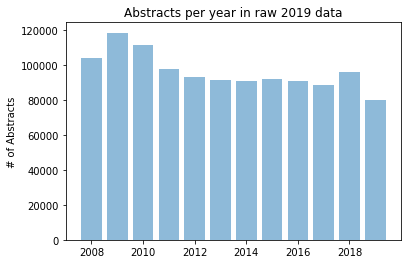

In [92]:
plt.bar(rawyear.index, rawyear, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('# of Abstracts')
plt.title('Abstracts per year in raw 2019 data')

plt.show()

In [56]:
year = df.FY.value_counts().sort_index()
year

2008.0    59358
2009.0    67105
2010.0    62811
2011.0    58063
2012.0    64272
2013.0    46712
2014.0    46504
2015.0    41189
2016.0    43037
2017.0    40929
2018.0    42837
2019.0    53156
Name: FY, dtype: int64

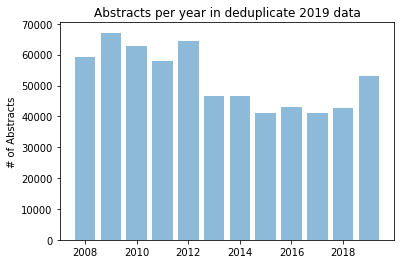

In [93]:
plt.bar(year.index, year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('# of Abstracts')
plt.title('Abstracts per year in deduplicate 2019 data')

plt.show()

In [58]:
oldyear = old.FY.value_counts().sort_index()
oldyear

2008    94846
2009    53413
2010    46349
2011    42761
2012    64056
2013    53345
2014    43325
2015    42252
2016    39681
2017    34619
2018    35441
Name: FY, dtype: int64

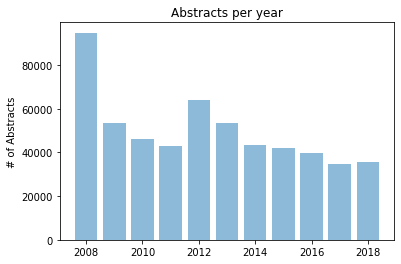

In [59]:
plt.bar(oldyear.index, oldyear, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('# of Abstracts')
plt.title('Abstracts per year')

plt.show()

### NAs per year

In [60]:
nans = df.isnull()
nans = nans.drop('FY', axis=1)
nans['FY'] = df['FY']

In [61]:
nans = nans.groupby('FY').sum()
nans

,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,...,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
FY,,,,,,,,,,,,,,,,,,,,,
2008.0,0.0,0.0,1689.0,0.0,0.0,0.0,59358.0,0.0,5677.0,5698.0,...,53.0,237.0,508.0,3306.0,237.0,59358.0,59358.0,9315.0,17462.0,59345.0
2009.0,0.0,0.0,0.0,0.0,0.0,0.0,67105.0,0.0,5742.0,5814.0,...,21.0,133.0,374.0,3107.0,133.0,67105.0,67105.0,8913.0,16107.0,67100.0
2010.0,0.0,0.0,0.0,0.0,0.0,0.0,62811.0,0.0,5965.0,6083.0,...,112.0,412.0,622.0,3382.0,408.0,62811.0,62811.0,9351.0,15142.0,62800.0
2011.0,0.0,0.0,0.0,0.0,0.0,0.0,58063.0,0.0,5036.0,5206.0,...,2.0,237.0,484.0,3167.0,240.0,58063.0,58063.0,8050.0,12975.0,58045.0
2012.0,0.0,0.0,0.0,0.0,0.0,0.0,15362.0,0.0,5846.0,6038.0,...,11.0,209.0,546.0,3243.0,208.0,19052.0,19055.0,8326.0,7086.0,59831.0
2013.0,0.0,0.0,0.0,0.0,0.0,0.0,46712.0,0.0,6281.0,6335.0,...,65.0,160.0,383.0,2658.0,159.0,46712.0,46712.0,8869.0,8100.0,46704.0
2014.0,0.0,0.0,0.0,0.0,0.0,0.0,15314.0,0.0,6364.0,6454.0,...,27.0,207.0,422.0,2658.0,204.0,18556.0,18557.0,8711.0,46444.0,46475.0
2015.0,0.0,0.0,0.0,0.0,0.0,0.0,16499.0,0.0,3983.0,3876.0,...,49.0,274.0,591.0,5304.0,206.0,20075.0,20075.0,5971.0,5471.0,38814.0
2016.0,0.0,0.0,0.0,0.0,0.0,0.0,16196.0,0.0,4402.0,4593.0,...,10.0,167.0,477.0,2488.0,94.0,19632.0,19633.0,6840.0,5844.0,39621.0


In [62]:
totalnan = nans.sum(axis = 1)
totalnan

FY
2008.0    341291.0
2009.0    373986.0
2010.0    353318.0
2011.0    323597.0
2012.0    209922.0
2013.0    264313.0
2014.0    214298.0
2015.0    160685.0
2016.0    159292.0
2017.0    137490.0
2018.0    142317.0
2019.0    172721.0
dtype: float64

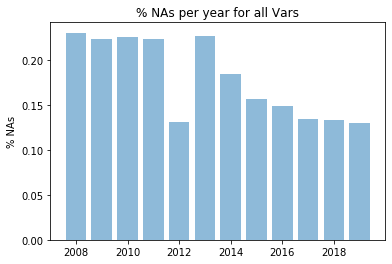

In [63]:
plt.bar(totalnan.index, totalnan/(year*len(df.columns)), align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('% NAs per year for all Vars')

plt.show()

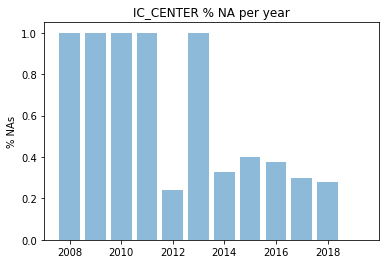

In [64]:
plt.bar(nans.index, nans.IC_CENTER/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('IC_CENTER % NA per year')

plt.show()

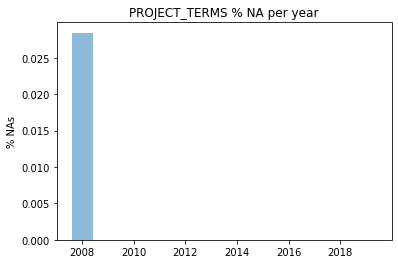

In [65]:
plt.bar(nans.index, nans.PROJECT_TERMS/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('PROJECT_TERMS % NA per year')

plt.show()

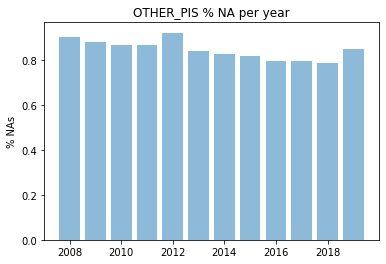

In [66]:
plt.bar(nans.index, nans.OTHER_PIS/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('OTHER_PIS % NA per year')

plt.show()

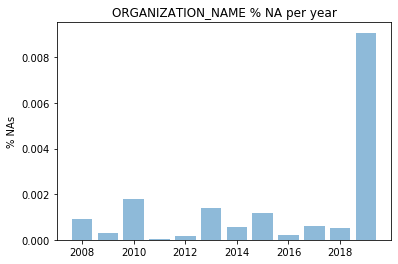

In [67]:
plt.bar(nans.index, nans.ORGANIZATION_NAME/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('ORGANIZATION_NAME % NA per year')

plt.show()

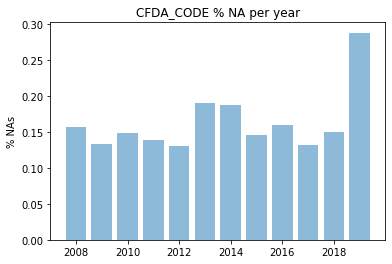

In [68]:
plt.bar(nans.index, nans.CFDA_CODE/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('CFDA_CODE % NA per year')

plt.show()

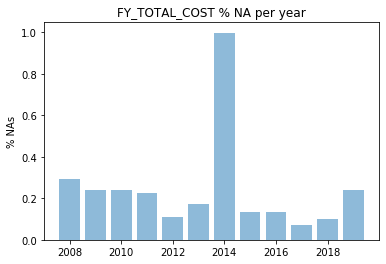

In [69]:
plt.bar(nans.index, nans.FY_TOTAL_COST/year, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.ylabel('% NAs')
plt.title('FY_TOTAL_COST % NA per year')

plt.show()

In [70]:
len(df[df.FY == 2014])

46504

In [71]:
df[df.FY == 2014]['FY_TOTAL_COST'].isnull().sum()

46444

In [72]:
df[df.FY == 2014]['FY_TOTAL_COST_SUB_PROJECTS'].isnull().sum()

46475

In [73]:
same = df.DEPARTMENT == df.AGENCY

In [74]:
same.sum()

144983

In [75]:
len(df) - same.sum()

480990

While there are no NAN values in DEPARTMENT or AGENCY, there are mismatched between them on ~5/6 of the rows